In [5]:
# 0) Imports & global config
import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, average_precision_score, f1_score
)
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
DATA_PATH = "dynamic_supply_chain_logistics_dataset.csv"  
EXPORT_DIR = Path("grb_outputs"); EXPORT_DIR.mkdir(exist_ok=True, parents=True)
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 120)

CFG = dict(
    time_col="timestamp",
    cost_col="shipping_costs",
    delay_prob_col="delay_probability",           
    delay_dev_col="delivery_time_deviation",
    risk_class_col="risk_classification",
    gps_lat="vehicle_gps_latitude",
    gps_lon="vehicle_gps_longitude",
    seg_cols=[
        "traffic_congestion_level",
        "weather_condition_severity",
        "supplier_reliability_score",
        "port_congestion_level"
    ],
)


In [6]:
# 1) Load & schema inference
df = pd.read_csv(DATA_PATH, low_memory=False)

if CFG["time_col"] not in df.columns:
    cand = None
    for c in df.columns:
        if df[c].dtype == "object":
            parsed = pd.to_datetime(df[c], errors="coerce", utc=True, infer_datetime_format=True)
            if parsed.notna().mean() > 0.8 and parsed.nunique() > 10:
                df[c] = parsed
                cand = c
                break
    CFG["time_col"] = cand
else:
    df[CFG["time_col"]] = pd.to_datetime(df[CFG["time_col"]], errors="coerce", utc=True)

print("Shape:", df.shape)
print("Time column:", CFG["time_col"])
print(df.head(3))


Shape: (32065, 26)
Time column: timestamp
                  timestamp  vehicle_gps_latitude  vehicle_gps_longitude  \
0 2021-01-01 00:00:00+00:00             40.375568             -77.014318   
1 2021-01-01 01:00:00+00:00             33.507818            -117.036902   
2 2021-01-01 02:00:00+00:00             30.020640             -75.269224   

   fuel_consumption_rate  eta_variation_hours  traffic_congestion_level  \
0               5.136512             4.998009                  5.927586   
1               5.101512             0.984929                  1.591992   
2               5.090803             4.972665                  8.787765   

   warehouse_inventory_level  loading_unloading_time  \
0                 985.716862                4.951392   
1                 396.700206                1.030379   
2                 832.408935                4.220229   

   handling_equipment_availability  order_fulfillment_status  \
0                         0.481294                  0.761166   

In [7]:
# 2) Data quality: missing, duplicates, outliers
quality = {
    "rows": len(df),
    "cols": df.shape[1],
    "duplicates": int(df.duplicated().sum()),
    "numeric_cols": int(df.select_dtypes(include=[np.number]).shape[1]),
    "categorical_cols": int(df.select_dtypes(include=["object","category"]).shape[1]),
    "datetime_cols": int(df.select_dtypes(include=["datetime64[ns, UTC]","datetime64[ns]"]).shape[1]),
}
pd.DataFrame(list(quality.items()), columns=["metric","value"])

na_tbl = df.isna().sum().sort_values(ascending=False)
na_tbl = pd.DataFrame({"missing_count": na_tbl, "missing_pct": na_tbl/len(df)})
na_tbl.head(15)

num_cols = df.select_dtypes(include=[np.number]).columns
z = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)
outlier_hits = (
    z.abs()
     .stack()
     .reset_index()
     .rename(columns={"level_0":"row","level_1":"column",0:"z"})
     .query("z > 3")
     .sort_values("z", ascending=False)
)
outlier_hits.head(20)


,row,column,z


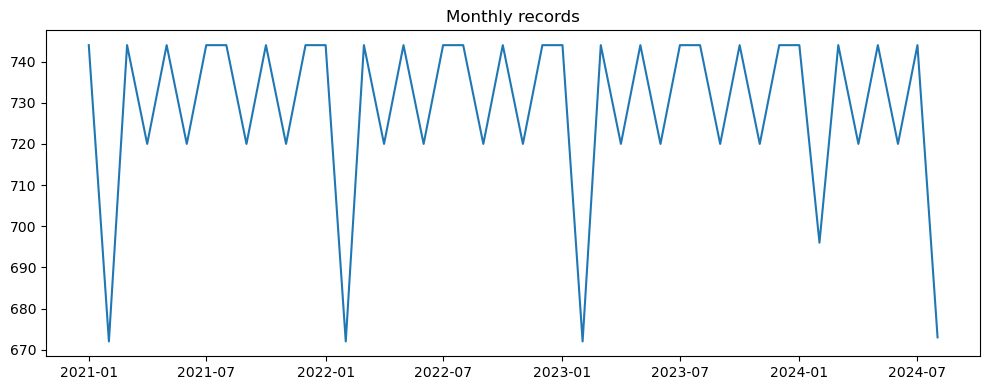

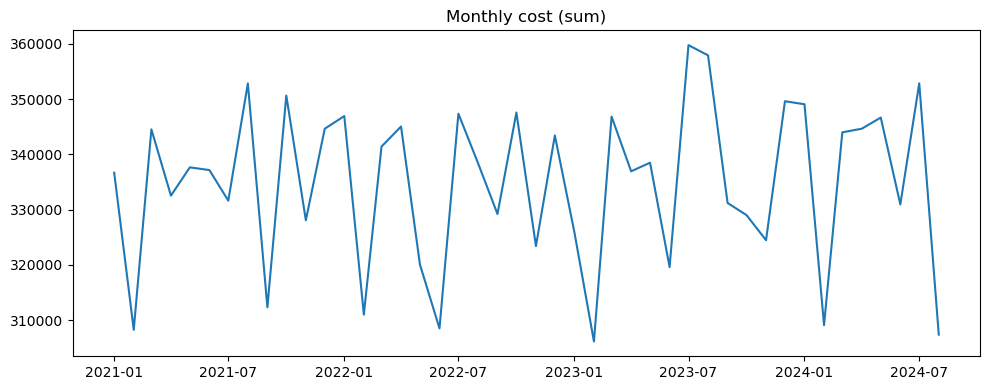

In [8]:
# 3) KPI & monthly snapshots
cost_col = CFG["cost_col"] if CFG["cost_col"] in df.columns else None
delay_prob_col = CFG["delay_prob_col"] if CFG["delay_prob_col"] in df.columns else None
delay_dev_col = CFG["delay_dev_col"] if CFG["delay_dev_col"] in df.columns else None
time_col = CFG["time_col"]

def kpi_snapshot():
    kpi = {}
    if cost_col: 
        kpi.update(dict(
            avg_shipping_cost=df[cost_col].mean(),
            p90_shipping_cost=df[cost_col].quantile(0.90),
            p99_shipping_cost=df[cost_col].quantile(0.99),
        ))
    if delay_prob_col:
        kpi["avg_delay_probability"] = df[delay_prob_col].mean()
    if delay_dev_col:
        kpi["avg_delivery_time_deviation"] = df[delay_dev_col].mean()
    return pd.DataFrame(list(kpi.items()), columns=["kpi","value"])

kpi_snapshot()

if time_col is not None:
    dfts = df.dropna(subset=[time_col]).copy()
    monthly = dfts.set_index(time_col).resample("MS")
    roll = pd.DataFrame({"records": monthly.size()})
    if cost_col: roll["cost_sum"] = monthly[cost_col].sum()
    if delay_prob_col: roll["delay_prob_sum"] = monthly[delay_prob_col].sum()
    if delay_dev_col: roll["delay_dev_sum"] = monthly[delay_dev_col].sum()
    roll.reset_index().rename(columns={time_col:"period"}).head()

 
    plt.figure(figsize=(10,4)); plt.plot(roll.index, roll["records"]); plt.title("Monthly records"); plt.tight_layout(); plt.show()
    if "cost_sum" in roll:
        plt.figure(figsize=(10,4)); plt.plot(roll.index, roll["cost_sum"]); plt.title("Monthly cost (sum)"); plt.tight_layout(); plt.show()


In [13]:
# 4) Segmentation — risk × congestion × weather × supplier × port
def qseg(s, q=4, labels=None):
    labels = labels or ["Q1","Q2","Q3","Q4"]
    try:
        return pd.qcut(s, q=q, labels=labels)
    except Exception:
        return pd.Series([np.nan]*len(s), index=s.index)

seg_cols = []
for c in CFG["seg_cols"]:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        sc = f"seg_{c}"
        df[sc] = qseg(df[c], q=4, labels=["Low","Med-Low","Med-High","High"])
        seg_cols.append(sc)

targets = [c for c in [cost_col, delay_prob_col, delay_dev_col] if c is not None]
group_keys = [c for c in seg_cols if c in df.columns]

if group_keys and targets:
    seg_tbl = (df.groupby(group_keys)[targets]
                 .agg(["mean","median","count"])
                 .sort_values((targets[0],"mean"), ascending=False))
    seg_tbl.head(20)


In [15]:
from IPython.display import display

print("Targets found:", [c for c in [CFG["cost_col"], CFG["delay_prob_col"], CFG["delay_dev_col"]] if c in df.columns])
print("Segment raw cols (CFG):", CFG["seg_cols"])
print("Segment generated cols:", [c for c in df.columns if c.startswith("seg_")])


if 'seg_tbl' in locals():
    display(seg_tbl.head(20))
else:
    print("0")


Targets found: ['shipping_costs', 'delay_probability', 'delivery_time_deviation']
Segment raw cols (CFG): ['traffic_congestion_level', 'weather_condition_severity', 'supplier_reliability_score', 'port_congestion_level']
Segment generated cols: ['seg_traffic_congestion_level', 'seg_weather_condition_severity', 'seg_supplier_reliability_score', 'seg_port_congestion_level']


shipping_costs  \
                                                                                                                               mean   
seg_traffic_congestion_level seg_weather_condition_severity seg_supplier_reliability_score seg_port_congestion_level                  
Med-Low                      Med-Low                        Low                            Low                           553.750212   
Low                          High                           High                           Low                           534.833630   
Med-Low                      Low                            Med-High                       High                          532.058915   
Low                          Med-Low                        Med-High                       Low                           521.920491   
                             Med-High                       Low                            Med-High                      521.375785   
Med-Low                      Med-High                       Med-Low                        High                          516.221039   
High                         Low                            High                           High                          512.609059   
Med-High                     Low                            Med-High                       Med-Low                       512.285966   
                             Med-Low                        High                           Low                           510.634576   
                             Med-High                       Med-Low                        Med-Low                       510.319844   
High                         Low                            Low                            Med-High                      506.006374   
Med-High                     Low                            High                           Low                           505.600212   
Med-Low                      Med-Low                        Med-High                       Low                           504.901185   
High                         Med-Low                        High                           Med-High                      503.838984   
                             High                           Low                            Low                           502.518426   
Med-High                     Med-Low                        Low                            High                          502.339171   
Med-Low                      Low                            Med-Low                        Med-High                      502.020445   
Low                          Med-Low                        Low                            High                          500.746887   
Med-High                     Med-High                       Low                            Low                           500.329698   
Low                          High                           Med-High                       Low                           498.995038   

                                                                                                                                  \
                                                                                                                          median   
seg_traffic_congestion_level seg_weather_condition_severity seg_supplier_reliability_score seg_port_congestion_level               
Med-Low                      Med-Low                        Low                            Low                        544.879322   
Low                          High                           High                           Low                        571.382453   
Med-Low                      Low                            Med-High                       High                       561.137573   
Low                          Med-Low                        Med-High                       Low                        489.664770   
                             Med-High                       Low                        

a) Traffic Congestion

shipping costs are slightly lower at higher congestion levels (458 at High vs. 462 at Med-High).

Delay probability and time deviation also remain almost flat across segments.

Interpretation: Congestion, as captured here, does not directly translate into higher costs or delays. Likely because pricing and scheduling buffers are already absorbing congestion risk upstream (contracts, routing, etc.).

b) Weather Severity

Higher weather severity reduces costs (454 at High vs. 461 at Low), which seems counterintuitive.

Delay probability is essentially unchanged.

Interpretation: Severe-weather routes may rely on optimized planning, risk premiums, or avoidance strategies. Costs appear lower because only essential/efficient shipments move in severe weather.

c) Supplier Reliability

Low reliability suppliers incur highest costs (464 vs. 456 at Med-Low).

Delay probability differences are marginal (~0.696–0.701).

Delivery deviation is fairly stable.

Interpretation: Reliability primarily impacts cost structures, not delays. Buyers pay more for buffers, inventory, or penalties when working with unreliable suppliers.

d) Port Congestion

Clearer pattern: higher congestion → lower costs but higher delays.

Costs: 462 (Low) → 456 (High).

Delay probability: 0.695 (Low) → 0.703 (High).

Deviation: 5.1 (Low) → 5.24 (High).

Interpretation: Firms may accept cheaper routes through congested ports but pay in terms of time reliability. This is a cost–time trade-off visible in operations.

In [16]:
from IPython.display import display

key_targets = [x for x in [CFG["cost_col"], CFG["delay_prob_col"], CFG["delay_dev_col"]] if x in df.columns]
for seg in [c for c in df.columns if c.startswith("seg_")]:
    tbl = df.groupby(seg)[key_targets].agg(["mean","median","count"]).sort_values((key_targets[0],"mean"), ascending=False)
    print(f"\n==== {seg} ====")
    display(tbl)



==== seg_traffic_congestion_level ====


shipping_costs                    \
                                       mean      median count   
seg_traffic_congestion_level                                    
Med-High                         462.364234  396.071463  8016   
Med-Low                          459.089781  387.297657  8016   
Low                              458.052041  385.033788  8017   
High                             457.991916  386.002924  8016   

                             delay_probability                  \
                                          mean    median count   
seg_traffic_congestion_level                                     
Med-High                              0.697990  0.832276  8016   
Med-Low                               0.699059  0.839757  8016   
Low                                   0.701132  0.845058  8017   
High                                  0.698125  0.841224  8016   

                             delivery_time_deviation                  
                                                mean    median count  
seg_traffic_congestion_level                                          
Med-High                                    5.125635  5.970646  8016  
Med-Low                                     5.186201  6.189661  8016  
Low                                         5.182887  6.140372  8017  
High                                        5.215869  6.146514  8016


==== seg_weather_condition_severity ====


shipping_costs                    \
                                         mean      median count   
seg_weather_condition_severity                                    
Low                                461.843131  395.587242  8017   
Med-High                           460.662027  392.227391  8016   
Med-Low                            460.606721  388.379921  8016   
High                               454.385619  381.235436  8016   

                               delay_probability                  \
                                            mean    median count   
seg_weather_condition_severity                                     
Low                                     0.698907  0.840493  8017   
Med-High                                0.696584  0.843159  8016   
Med-Low                                 0.700047  0.835993  8016   
High                                    0.700769  0.838906  8016   

                               delivery_time_deviation                  
                                                  mean    median count  
seg_weather_condition_severity                                          
Low                                           5.187525  6.087742  8017  
Med-High                                      5.161904  6.075696  8016  
Med-Low                                       5.160597  6.132333  8016  
High                                          5.200565  6.152089  8016


==== seg_supplier_reliability_score ====


shipping_costs                    \
                                         mean      median count   
seg_supplier_reliability_score                                    
Low                                463.815128  401.222044  8017   
High                               461.074087  391.236528  8016   
Med-Low                            456.408669  385.716987  8016   
Med-High                           456.199369  379.376511  8016   

                               delay_probability                  \
                                            mean    median count   
seg_supplier_reliability_score                                     
Low                                     0.699672  0.843162  8017   
High                                    0.701483  0.843036  8016   
Med-Low                                 0.696355  0.832227  8016   
Med-High                                0.698797  0.838118  8016   

                               delivery_time_deviation                  
                                                  mean    median count  
seg_supplier_reliability_score                                          
Low                                           5.168952  6.119794  8017  
High                                          5.185266  6.122103  8016  
Med-Low                                       5.161928  6.072796  8016  
Med-High                                      5.194446  6.131139  8016


==== seg_port_congestion_level ====


shipping_costs                   delay_probability  \
                                    mean      median count              mean   
seg_port_congestion_level                                                      
Low                           462.296050  391.349575  8017          0.694729   
Med-Low                       460.773100  390.833265  8016          0.697818   
Med-High                      458.390568  387.685910  8016          0.700917   
High                          456.037725  384.523585  8016          0.702843   

                                          delivery_time_deviation            \
                             median count                    mean    median   
seg_port_congestion_level                                                     
Low                        0.835293  8017                5.108173  6.034213   
Med-Low                    0.838584  8016                5.209716  6.176436   
Med-High                   0.839921  8016                5.148428  5.998777   
High                       0.843391  8016                5.244283  6.252773   

                                 
                          count  
seg_port_congestion_level        
Low                        8017  
Med-Low                    8016  
Med-High                   8016  
High                       8016

In [19]:
# 5) Features & preprocessing pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def split_Xy(data: pd.DataFrame, y_col: str, drop_also=()):
    drop_cols = set(drop_also) | {y_col}
    for other in [CFG.get("cost_col"), CFG.get("delay_prob_col"), CFG.get("delay_dev_col")]:
        if other and other != y_col and other in data.columns:
            drop_cols.add(other)
    tc = CFG.get("time_col")
    if tc and tc in data.columns:
        drop_cols.add(tc)
    X = data.drop(columns=[c for c in drop_cols if c in data.columns]).copy()
    y = data[y_col].copy()
    return X, y

def build_preprocessor(X: pd.DataFrame):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler",  StandardScaler())
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ],
        remainder="drop"
    )
    return pre


[COST] MAE: 280.5569981309673
[COST] RMSE: 336.82252157430696
[COST] R2: -0.15538534779590174


,feature,importance
2,num__fuel_consumption_rate,0.001048
8,num__order_fulfillment_status,0.001047
18,num__driver_behavior_score,0.000352
4,num__traffic_congestion_level,0.000305
6,num__loading_unloading_time,0.000251
5,num__warehouse_inventory_level,0.000224
12,num__lead_time_days,0.000223
21,cat__risk_classification_High Risk,0.000014
22,cat__risk_classification_Low Risk,0.000013
24,cat__seg_traffic_congestion_level_High,0.000003


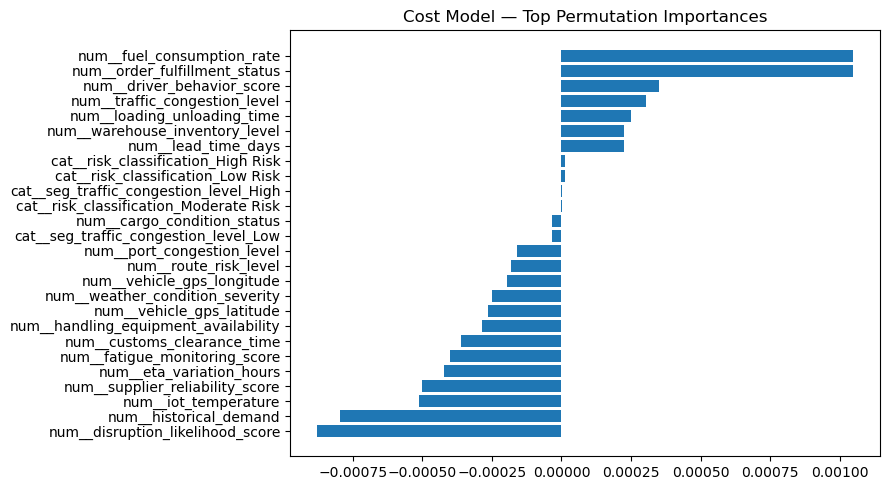

In [20]:
# 6) Cost regression (GBR, log-target) + permutation importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

cost_col = CFG.get("cost_col")
time_col = CFG.get("time_col")

if cost_col and cost_col in df.columns:
    data = df.dropna(subset=[cost_col]).copy()
    X, y = split_Xy(data, cost_col)

    pre = build_preprocessor(X)
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    pipe = Pipeline([("pre", pre), ("model", model)])


    if time_col and time_col in data.columns and data[time_col].notna().any():
        dsort = data.sort_values(time_col)
        split = int(0.8 * len(dsort))
        tr_idx, te_idx = dsort.index[:split], dsort.index[split:]
    else:
        tr_idx, te_idx = train_test_split(data.index, test_size=0.2, random_state=RANDOM_STATE)

    y_log = np.log1p(y)
    pipe.fit(X.loc[tr_idx], y_log.loc[tr_idx])


    pred_log = pipe.predict(X.loc[te_idx])
    pred = np.expm1(pred_log)

    mae = mean_absolute_error(y.loc[te_idx], pred)
    rmse = np.sqrt(mean_squared_error(y.loc[te_idx], pred))
    r2 = r2_score(y.loc[te_idx], pred)

    print("[COST] MAE:", mae)
    print("[COST] RMSE:", rmse)
    print("[COST] R2:", r2)

    pi = permutation_importance(pipe, X.loc[te_idx], y_log.loc[te_idx], n_repeats=5, random_state=RANDOM_STATE)

    try:
        feat_names = pipe.named_steps["pre"].get_feature_names_out().tolist()
    except Exception:
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
        ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["oh"] if cat_cols else None
        cat_out = ohe.get_feature_names_out(cat_cols).tolist() if ohe is not None else []
        feat_names = num_cols + cat_out

    n = min(len(feat_names), len(pi.importances_mean))
    cost_importance = (
        pd.DataFrame({"feature": feat_names[:n], "importance": pi.importances_mean[:n]})
          .sort_values("importance", ascending=False)
          .head(30)
    )
    display(cost_importance)

    plt.figure(figsize=(9,5))
    plt.barh(range(len(cost_importance)), cost_importance["importance"].values[::-1])
    plt.yticks(range(len(cost_importance)), cost_importance["feature"].values[::-1])
    plt.title("Cost Model — Top Permutation Importances")
    plt.tight_layout()
    plt.show()
else:
    print("No `shipping_costs` column found — skip cost model.")


In [21]:
# 7A) Reliability as regression: delivery_time_deviation
delay_dev_col = CFG.get("delay_dev_col")

if delay_dev_col and delay_dev_col in df.columns:
    data = df.dropna(subset=[delay_dev_col]).copy()
    X, y = split_Xy(data, delay_dev_col)

    pre = build_preprocessor(X)
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    pipe = Pipeline([("pre", pre), ("model", model)])

    if time_col and time_col in data.columns and data[time_col].notna().any():
        dsort = data.sort_values(time_col)
        split = int(0.8 * len(dsort))
        tr_idx, te_idx = dsort.index[:split], dsort.index[split:]
    else:
        tr_idx, te_idx = train_test_split(data.index, test_size=0.2, random_state=RANDOM_STATE)

    pipe.fit(X.loc[tr_idx], y.loc[tr_idx])
    pred = pipe.predict(X.loc[te_idx])

    mae = mean_absolute_error(y.loc[te_idx], pred)
    rmse = np.sqrt(mean_squared_error(y.loc[te_idx], pred))
    r2 = r2_score(y.loc[te_idx], pred)

    print("[DELAY_DEV] MAE:", mae)
    print("[DELAY_DEV] RMSE:", rmse)
    print("[DELAY_DEV] R2:", r2)
else:
    print("No `delivery_time_deviation` column found — skip 7A.")


[DELAY_DEV] MAE: 3.7027461525241776
[DELAY_DEV] RMSE: 4.174453957926055
[DELAY_DEV] R2: -0.005271234658846824


In [22]:
# 7B) Reliability as classification: is_delayed from delivery_time_deviation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

delay_dev_col = CFG.get("delay_dev_col")

if delay_dev_col and delay_dev_col in df.columns:
    data = df.dropna(subset=[delay_dev_col]).copy()
   
    THRESH = data[delay_dev_col].quantile(0.75)
    data["is_delayed"] = (data[delay_dev_col] > THRESH).astype(int)

    X, y = split_Xy(data, "is_delayed")
    pre = build_preprocessor(X)
    clf = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced")
    pipe = Pipeline([("pre", pre), ("model", clf)])

    if time_col and time_col in data.columns and data[time_col].notna().any():
        dsort = data.sort_values(time_col)
        split = int(0.8 * len(dsort))
        tr_idx, te_idx = dsort.index[:split], dsort.index[split:]
    else:
        tr_idx, te_idx = train_test_split(data.index, test_size=0.2, random_state=RANDOM_STATE)

    pipe.fit(X.loc[tr_idx], y.loc[tr_idx])
    proba = pipe.predict_proba(X.loc[te_idx])[:, 1]
    pred = (proba >= 0.5).astype(int)

    print("[DELAY_CLS] AUC:", roc_auc_score(y.loc[te_idx], proba))
    print("[DELAY_CLS] AUPRC:", average_precision_score(y.loc[te_idx], proba))
    print("[DELAY_CLS] F1:", f1_score(y.loc[te_idx], pred))
else:
    print("No `delivery_time_deviation` column found — skip 7B.")


[DELAY_CLS] AUC: 0.49738061919673027
[DELAY_CLS] AUPRC: 0.2480566755325467
[DELAY_CLS] F1: 0.0
